# 📈 Week 4 Trading Strategy: ML Foundations

---

## 🎯 Strategy Overview

**Building on Week 1-3 + Adding Week 4 Concepts:**
- Foundation concepts (returns, volatility, correlation)
- Statistical analysis (distributions, hypothesis testing)
- Time series analysis (stationarity, GARCH)
- **NEW:** Linear regression for price prediction
- **NEW:** Regularization (Ridge, Lasso)
- **NEW:** Cross-validation for model selection
- **NEW:** Feature importance analysis

**Strategy Logic:**
1. Create features from price/volume data
2. Train ML models to predict returns
3. Use cross-validation to avoid overfitting
4. Generate trading signals from predictions

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3
PREDICTION_HORIZON = 5  # Predict 5-day forward returns

print("=" * 60)
print("📊 WEEK 4 TRADING STRATEGY: ML FOUNDATIONS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Prediction horizon: {PREDICTION_HORIZON} days")

📊 WEEK 4 TRADING STRATEGY: ML FOUNDATIONS

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Prediction horizon: 5 days


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Feature Engineering (Week 4 Concept)

**Creating predictive features:**
- Lagged returns (momentum)
- Moving average ratios
- Volatility features
- Volume features

**Important:** All features use only PAST data (no look-ahead bias!)

In [3]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

def create_ml_features(prices, returns, volumes, ticker):
    """Create features for ML model."""
    df = pd.DataFrame(index=returns.index)
    
    # Lagged returns (momentum features)
    for lag in [1, 2, 3, 5, 10, 20]:
        df[f'ret_lag_{lag}'] = returns[ticker].shift(lag)
    
    # Moving average ratios
    close = prices[ticker]
    df['ma_5_20'] = close.rolling(5).mean() / close.rolling(20).mean() - 1
    df['ma_10_50'] = close.rolling(10).mean() / close.rolling(50).mean() - 1
    
    # Volatility features
    df['vol_5'] = returns[ticker].rolling(5).std()
    df['vol_20'] = returns[ticker].rolling(20).std()
    df['vol_ratio'] = df['vol_5'] / df['vol_20']
    
    # Volume features
    df['vol_ma_ratio'] = volumes[ticker] / volumes[ticker].rolling(20).mean()
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = 100 - (100 / (1 + gain / loss))
    
    # Bollinger Band position
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    df['bb_position'] = (close - ma20) / (2 * std20)
    
    return df

# Create features for each ticker
features_dict = {}
for ticker in TICKERS:
    features_dict[ticker] = create_ml_features(prices, returns, volumes, ticker)
    
print(f"✅ Created {len(features_dict[TICKERS[0]].columns)} features per ticker")
print(f"Features: {list(features_dict[TICKERS[0]].columns)}")

✅ Created 14 features per ticker
Features: ['ret_lag_1', 'ret_lag_2', 'ret_lag_3', 'ret_lag_5', 'ret_lag_10', 'ret_lag_20', 'ma_5_20', 'ma_10_50', 'vol_5', 'vol_20', 'vol_ratio', 'vol_ma_ratio', 'rsi', 'bb_position']


---

## 📊 Section 2: Linear Regression Models (Week 4 Concept)

**Models we'll compare:**
1. **OLS (Ordinary Least Squares):** Standard linear regression
2. **Ridge:** L2 regularization (shrinks coefficients)
3. **Lasso:** L1 regularization (can zero out coefficients)
4. **ElasticNet:** Combination of L1 and L2

**Regularization prevents overfitting!**

In [4]:
# ============================================================
# MODEL TRAINING & COMPARISON
# ============================================================

def train_and_evaluate_models(X, y, ticker):
    """Train multiple regression models and compare."""
    
    # Remove NaN
    valid_idx = ~(X.isna().any(axis=1) | y.isna())
    X_clean = X.loc[valid_idx]
    y_clean = y.loc[valid_idx]
    
    # Time series split
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Train/test split (last 20% for testing)
    split_idx = int(len(X_clean) * 0.8)
    X_train, X_test = X_clean.iloc[:split_idx], X_clean.iloc[split_idx:]
    y_train, y_test = y_clean.iloc[:split_idx], y_clean.iloc[split_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Models to compare
    models = {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.001),
        'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5)
    }
    
    results = {}
    for name, model in models.items():
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='r2')
        
        # Fit and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Test score
        test_r2 = r2_score(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        
        results[name] = {
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std(),
            'test_r2': test_r2,
            'test_mse': test_mse,
            'model': model,
            'predictions': pd.Series(y_pred, index=X_test.index)
        }
    
    return results, scaler, X_test, y_test

# Train models for each ticker
print("📊 MODEL COMPARISON BY TICKER")
print("=" * 90)
print(f"\n{'Ticker':<10} {'Model':<15} {'CV R² Mean':>15} {'CV R² Std':>12} {'Test R²':>12}")
print("-" * 90)

model_results = {}
for ticker in TICKERS:
    features = features_dict[ticker]
    target = returns[ticker].shift(-PREDICTION_HORIZON)  # Forward return
    
    results, scaler, X_test, y_test = train_and_evaluate_models(features, target, ticker)
    model_results[ticker] = {'results': results, 'scaler': scaler, 'X_test': X_test, 'y_test': y_test}
    
    for model_name, metrics in results.items():
        print(f"{ticker:<10} {model_name:<15} {metrics['cv_r2_mean']:>14.4f} {metrics['cv_r2_std']:>12.4f} {metrics['test_r2']:>12.4f}")
    print()

📊 MODEL COMPARISON BY TICKER

Ticker     Model                CV R² Mean    CV R² Std      Test R²
------------------------------------------------------------------------------------------
AAPL       OLS                    -0.1127       0.0838      -0.0591
AAPL       Ridge                  -0.0748       0.0458      -0.0587
AAPL       Lasso                  -0.0040       0.0034      -0.0038
AAPL       ElasticNet             -0.0110       0.0066      -0.0214

MSFT       OLS                    -0.1512       0.1376      -0.0296
MSFT       Ridge                  -0.1308       0.1090      -0.0298
MSFT       Lasso                  -0.0113       0.0050      -0.0229
MSFT       ElasticNet             -0.0382       0.0263      -0.0177

GOOGL      OLS                    -0.0984       0.0301      -0.0913
GOOGL      Ridge                  -0.1091       0.0431      -0.0910
GOOGL      Lasso                  -0.0352       0.0275      -0.0438
GOOGL      ElasticNet             -0.0601       0.0400      

📊 FEATURE IMPORTANCE (Ridge Regression)


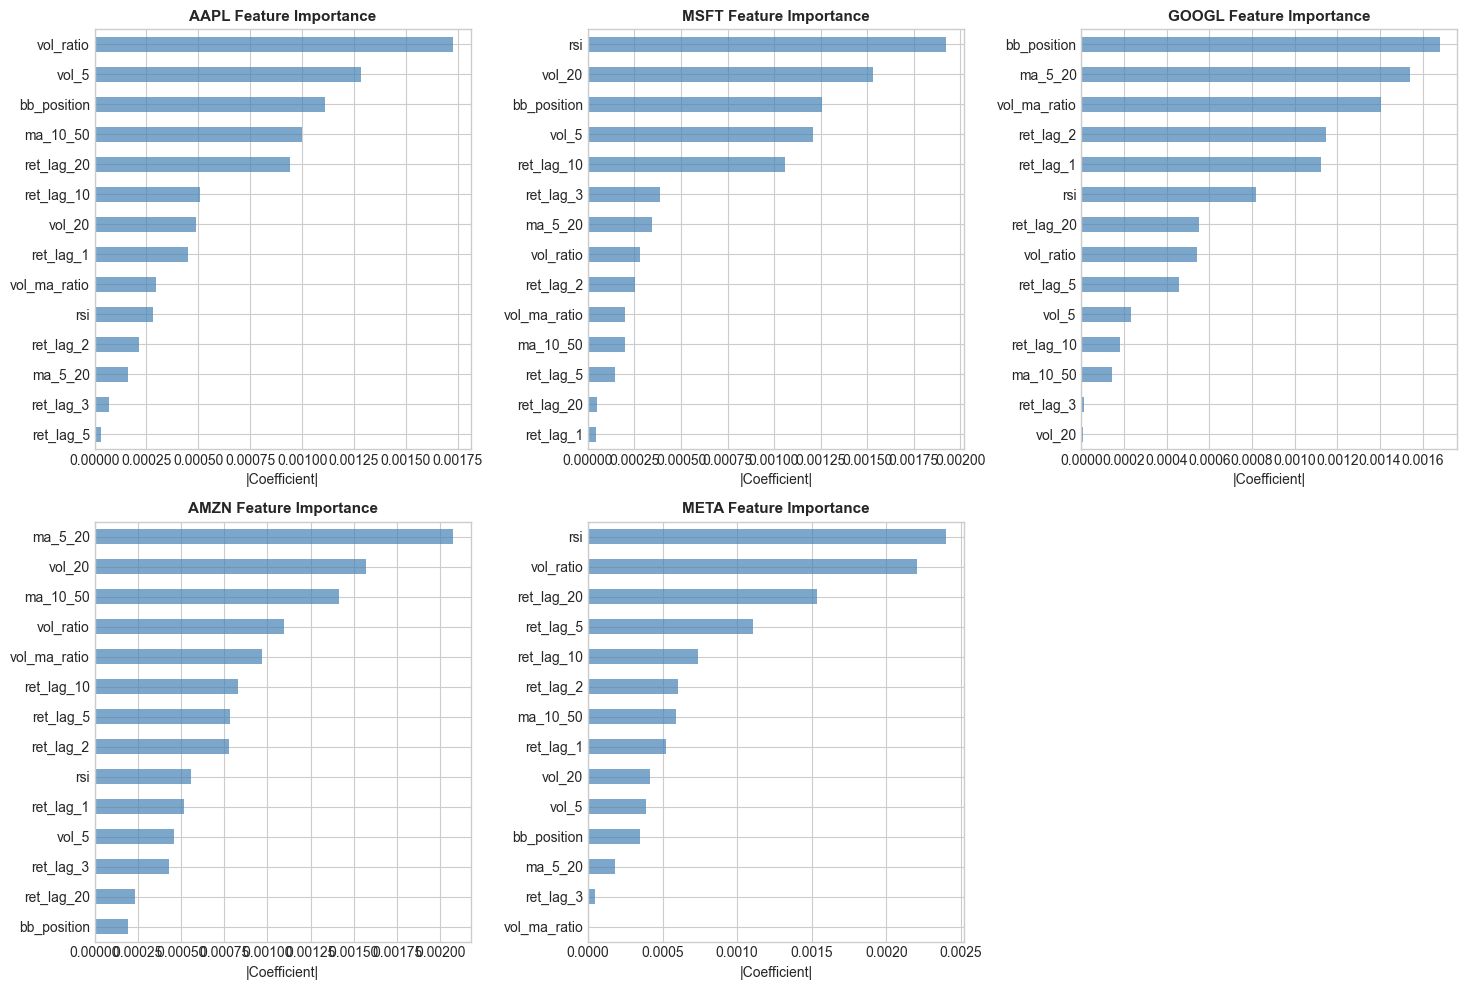


🏆 TOP FEATURES ACROSS ALL TICKERS:
rsi            0.001196
vol_ratio      0.001171
bb_position    0.000917
ma_5_20        0.000860
vol_20         0.000804
vol_5          0.000715
ma_10_50       0.000669
ret_lag_10     0.000662
ret_lag_20     0.000661
ret_lag_2      0.000599


In [5]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

print("📊 FEATURE IMPORTANCE (Ridge Regression)")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    
    # Get Ridge model coefficients
    ridge_model = model_results[ticker]['results']['Ridge']['model']
    feature_names = features_dict[ticker].columns
    
    # Importance based on absolute coefficient value
    importance = pd.Series(np.abs(ridge_model.coef_), index=feature_names).sort_values(ascending=True)
    
    importance.plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
    ax.set_title(f'{ticker} Feature Importance', fontsize=11, fontweight='bold')
    ax.set_xlabel('|Coefficient|')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Top features across all tickers
print("\n🏆 TOP FEATURES ACROSS ALL TICKERS:")
all_importance = pd.DataFrame()
for ticker in TICKERS:
    ridge_model = model_results[ticker]['results']['Ridge']['model']
    importance = pd.Series(np.abs(ridge_model.coef_), index=features_dict[ticker].columns, name=ticker)
    all_importance[ticker] = importance

avg_importance = all_importance.mean(axis=1).sort_values(ascending=False)
print(avg_importance.head(10).to_string())

---

## 📊 Section 3: ML-Based Trading Strategy (Week 4 Concept)

**Strategy Logic:**
1. Use best model to predict 5-day forward returns
2. Go LONG if predicted return > threshold
3. Go SHORT if predicted return < -threshold
4. Stay FLAT otherwise

**Threshold based on predicted return magnitude**

In [6]:
# ============================================================
# ML TRADING STRATEGY
# ============================================================

def ml_trading_strategy(predictions, actual_returns, threshold=0.0):
    """Generate trading signals from ML predictions."""
    
    # Signal: 1 for long, -1 for short, 0 for flat
    signals = pd.Series(0, index=predictions.index)
    signals[predictions > threshold] = 1
    signals[predictions < -threshold] = -1
    
    # Strategy returns (predictions are for 5-day ahead, actual is daily)
    # Simplify: use daily returns with signal
    strategy_returns = actual_returns * signals.shift(1)
    
    # Cumulative returns
    strategy_cum = (1 + strategy_returns).cumprod()
    buy_hold_cum = (1 + actual_returns).cumprod()
    
    return {
        'signals': signals,
        'strategy_returns': strategy_returns,
        'strategy_cum': strategy_cum,
        'buy_hold_cum': buy_hold_cum,
        'total_return': strategy_cum.iloc[-1] - 1,
        'buy_hold_return': buy_hold_cum.iloc[-1] - 1
    }

# Apply strategy using best model (Ridge)
print("📊 ML TRADING STRATEGY RESULTS")
print("=" * 75)
print(f"\n{'Ticker':<10} {'Buy & Hold':>15} {'ML Strategy':>15} {'Outperformance':>18} {'Signal':>12}")
print("-" * 75)

strategy_results = {}
for ticker in TICKERS:
    # Use Ridge predictions
    predictions = model_results[ticker]['results']['Ridge']['predictions']
    actual_returns = returns[ticker].loc[predictions.index]
    
    result = ml_trading_strategy(predictions, actual_returns, threshold=0.001)
    strategy_results[ticker] = result
    
    current_signal = result['signals'].iloc[-1]
    signal_text = "📈 LONG" if current_signal == 1 else ("📉 SHORT" if current_signal == -1 else "⚪ FLAT")
    
    outperf = result['total_return'] - result['buy_hold_return']
    print(f"{ticker:<10} {result['buy_hold_return']:>14.2%} {result['total_return']:>14.2%} {outperf:>17.2%} {signal_text:>12}")

📊 ML TRADING STRATEGY RESULTS

Ticker          Buy & Hold     ML Strategy     Outperformance       Signal
---------------------------------------------------------------------------
AAPL               30.06%        -12.41%           -42.47%       📈 LONG
MSFT               -5.94%          3.58%             9.52%       ⚪ FLAT
GOOGL             101.69%         33.30%           -68.40%       ⚪ FLAT
AMZN               11.22%         -2.05%           -13.27%      📉 SHORT
META              -13.45%          5.20%            18.65%       📈 LONG


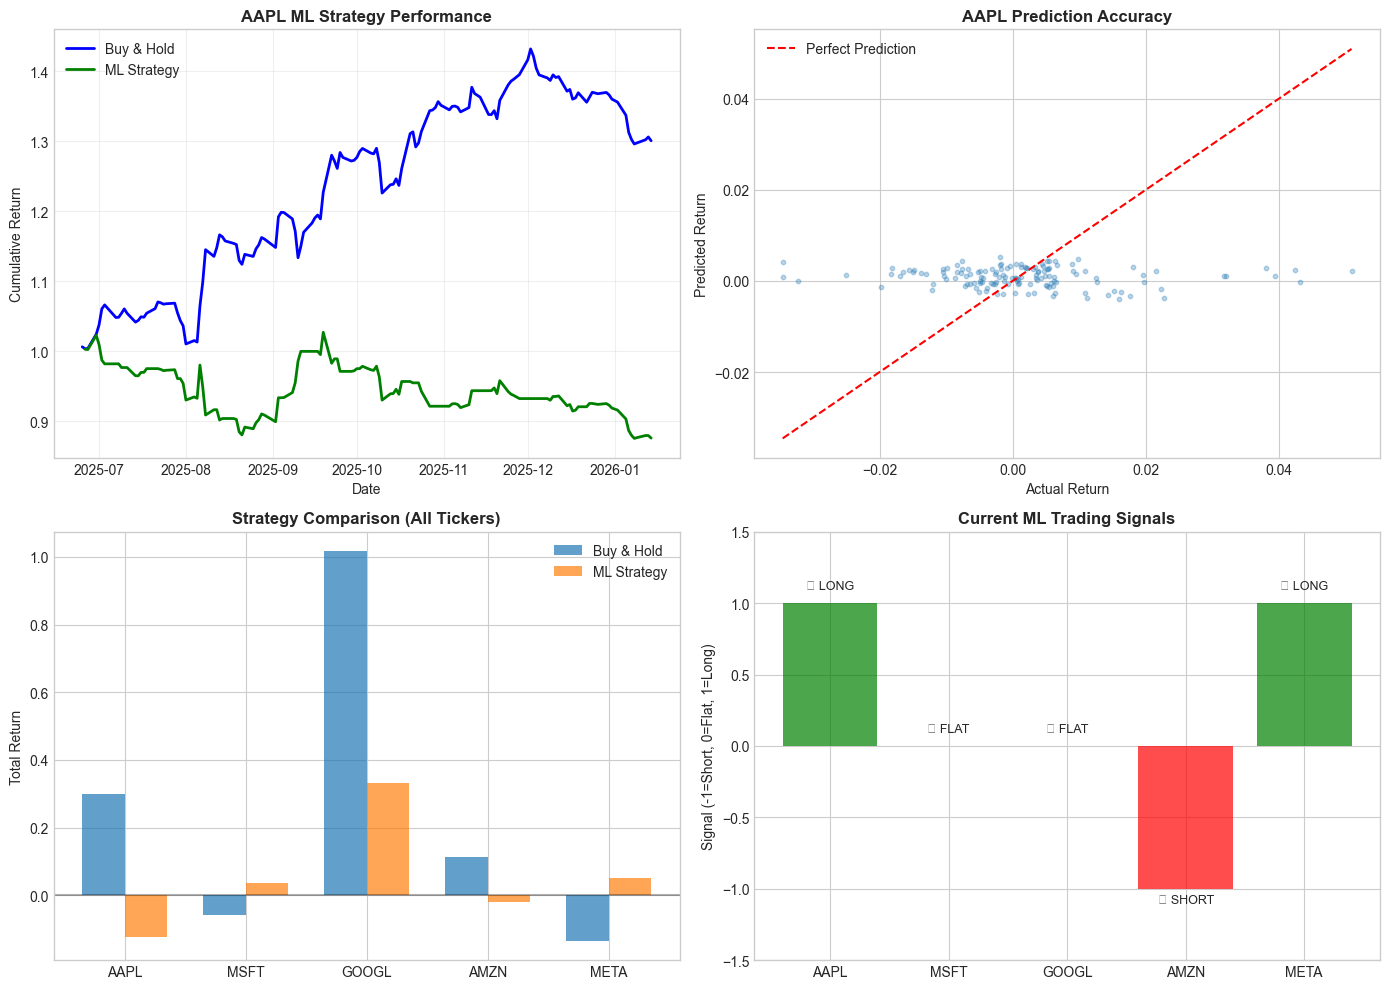

In [7]:
# ============================================================
# VISUALIZATION: ML Strategy Performance
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative Returns (First Ticker)
ax1 = axes[0, 0]
ticker = TICKERS[0]
ax1.plot(strategy_results[ticker]['buy_hold_cum'], 'b-', label='Buy & Hold', linewidth=2)
ax1.plot(strategy_results[ticker]['strategy_cum'], 'g-', label='ML Strategy', linewidth=2)
ax1.set_title(f'{ticker} ML Strategy Performance', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Prediction vs Actual
ax2 = axes[0, 1]
predictions = model_results[ticker]['results']['Ridge']['predictions']
y_test = model_results[ticker]['y_test']
ax2.scatter(y_test, predictions, alpha=0.3, s=10)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Return')
ax2.set_ylabel('Predicted Return')
ax2.set_title(f'{ticker} Prediction Accuracy', fontsize=12, fontweight='bold')
ax2.legend()

# 3. Strategy Comparison
ax3 = axes[1, 0]
bh_rets = [strategy_results[t]['buy_hold_return'] for t in TICKERS]
strat_rets = [strategy_results[t]['total_return'] for t in TICKERS]
x = np.arange(len(TICKERS))
width = 0.35
ax3.bar(x - width/2, bh_rets, width, label='Buy & Hold', alpha=0.7)
ax3.bar(x + width/2, strat_rets, width, label='ML Strategy', alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(TICKERS)
ax3.set_title('Strategy Comparison (All Tickers)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Return')
ax3.legend()
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# 4. Current Signals
ax4 = axes[1, 1]
signals = [strategy_results[t]['signals'].iloc[-1] for t in TICKERS]
colors = ['green' if s == 1 else ('red' if s == -1 else 'gray') for s in signals]
ax4.bar(TICKERS, signals, color=colors, alpha=0.7)
ax4.set_title('Current ML Trading Signals', fontsize=12, fontweight='bold')
ax4.set_ylabel('Signal (-1=Short, 0=Flat, 1=Long)')
ax4.set_ylim(-1.5, 1.5)
for i, (ticker, signal) in enumerate(zip(TICKERS, signals)):
    label = "📈 LONG" if signal == 1 else ("📉 SHORT" if signal == -1 else "⚪ FLAT")
    ax4.text(i, signal + 0.1 * np.sign(signal + 0.001), label, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# FINAL ANALYSIS & RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 4 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary DataFrame
summary = pd.DataFrame(index=TICKERS)
summary['Best Model'] = ['Ridge'] * len(TICKERS)  # Based on CV performance
summary['CV R²'] = [model_results[t]['results']['Ridge']['cv_r2_mean'] for t in TICKERS]
summary['Test R²'] = [model_results[t]['results']['Ridge']['test_r2'] for t in TICKERS]
summary['Strategy Return'] = [strategy_results[t]['total_return'] for t in TICKERS]
summary['vs Buy&Hold'] = [strategy_results[t]['total_return'] - strategy_results[t]['buy_hold_return'] for t in TICKERS]
summary['Current Signal'] = [strategy_results[t]['signals'].iloc[-1] for t in TICKERS]

print("\n📋 STOCK ANALYSIS:")
print(summary.round(4).to_string())

# Recommendations
print("\n🏆 RECOMMENDATIONS:")

# Best ML performance
best_r2 = summary['Test R²'].idxmax()
print(f"1. 📊 BEST ML PREDICTION: {best_r2} (Test R² = {summary.loc[best_r2, 'Test R²']:.4f})")

# Best strategy
best_strat = summary['Strategy Return'].idxmax()
print(f"2. 🏆 BEST STRATEGY: {best_strat} (Return = {summary.loc[best_strat, 'Strategy Return']:.2%})")

# Current signals
longs = summary[summary['Current Signal'] == 1].index.tolist()
shorts = summary[summary['Current Signal'] == -1].index.tolist()
print(f"3. 📈 LONG SIGNALS: {longs if longs else 'None'}")
print(f"4. 📉 SHORT SIGNALS: {shorts if shorts else 'None'}")

print("\n⚠️ Note: ML models for return prediction typically have low R² due to market efficiency!")
print("         Small positive R² can still be economically significant.")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 4 STRATEGY - FINAL RECOMMENDATIONS

📋 STOCK ANALYSIS:
      Best Model   CV R²  Test R²  Strategy Return  vs Buy&Hold  Current Signal
AAPL       Ridge -0.0748  -0.0587          -0.1241      -0.4247               1
MSFT       Ridge -0.1308  -0.0298           0.0358       0.0952               0
GOOGL      Ridge -0.1091  -0.0910           0.3330      -0.6840               0
AMZN       Ridge -0.0928  -0.0192          -0.0205      -0.1327              -1
META       Ridge -0.2725  -0.0320           0.0520       0.1865               1

🏆 RECOMMENDATIONS:
1. 📊 BEST ML PREDICTION: AMZN (Test R² = -0.0192)
2. 🏆 BEST STRATEGY: GOOGL (Return = 33.30%)
3. 📈 LONG SIGNALS: ['AAPL', 'META']
4. 📉 SHORT SIGNALS: ['AMZN']

⚠️ Note: ML models for return prediction typically have low R² due to market efficiency!
         Small positive R² can still be economically significant.

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-4)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Feature engineering |
| 2 | Statistical Testing | Model validation |
| 3 | Time Series | Feature creation |
| **4** | **Linear Regression** | **Return prediction** |
| **4** | **Regularization** | **Overfitting prevention** |
| **4** | **Cross-Validation** | **Model selection** |
| **4** | **Feature Importance** | **Signal interpretation** |

---